In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.interpolate import interp1d

### LOAD CLUSTER LABELS 

In [3]:
### LOAD CLUSTER LABELS ##################
def load_cluster_labels(index_info_path, sourcefile_list=None, min_cluster_size=None):
    """
    Load specific cluster label column from an index_info.csv file with multi-index set.

    Args:
        index_info_path (str): Full path to the index_info.csv file.
        sourcefile_list (list, optional): List of specific SourceFile indices to select. Uses all if None.
        min_cluster_size (int, optional): Value of min_cluster_size for the Clusterlabel_{min_cluster_size} column.

    Returns:
        pandas.Series: Returns specific cluster label column or whole cluster label column if min_cluster_size = None.
    """
    # Load index_info.csv file with multi-index set to SourceFile, RowIndex, and VideoPath
    index_info_df = pd.read_csv(index_info_path, index_col=["SourceFile", "RowIndex", "VideoPath"])

    # If min_cluster_size is provided, select the corresponding cluster label column
    if min_cluster_size is not None:
        cluster_label_column = f"Softlabel_{min_cluster_size}"
        
        if cluster_label_column not in index_info_df.columns:
            raise ValueError(f"{cluster_label_column} column does not exist in index_info.csv.")
        
        # Select only the cluster label column (as a Series)
        cluster_labels = index_info_df[cluster_label_column]
        
        # If sourcefile_list is provided, select only the corresponding indices
        if sourcefile_list is not None:
            # Select only the SourceFile indices corresponding to sourcefile_list
            cluster_labels = cluster_labels.loc[sourcefile_list]
            
        return cluster_labels
    
    # If min_cluster_size is not provided, return the entire DataFrame
    return index_info_df

### ETHOGRAM

In [19]:
### DRAW ETHOGRAM ##########################################3 
def create_ethogram(cluster_labels, video_name, output_path=None):
    """
    Create an ethogram based on cluster labels.

    Args:
        cluster_labels (pd.Series): A series containing the cluster labels ordered by frame.
        video_name (str): Name of the video for the plot title.
        output_path (str, optional): Path to save the ethogram image. If None, the plot will be shown.

    Returns:
        None
    """
    # 클러스터 라벨을 프레임 순서로 나열
    unique_labels = cluster_labels.unique()
    #num_clusters = len(unique_labels)
    num_clusters = 43
    print(num_clusters)

    # 색상 팔레트 설정: num_clusters에 따라 다른 팔레트 사용
    if num_clusters > 18:
        palette = sns.color_palette('Spectral', num_clusters)
    else:
        palette = sns.color_palette('tab20', num_clusters)

    # 라벨을 숫자로 매핑
    label_to_color = {label: palette[i] for i, label in enumerate(unique_labels) if label != -1}
    label_to_color[-1] = (0.5, 0.5, 0.5)  # 회색 지정
    
    # 각 프레임에 해당하는 색상을 선택
    ethogram_colors = [label_to_color[label] for label in cluster_labels]

    # ethogram 그리기
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(cluster_labels)), np.ones(len(cluster_labels)), color=ethogram_colors, width=1)
    plt.title(f'Ethogram for {video_name}')
    plt.xlabel('Frames')
    plt.ylabel('Behavior')
    plt.yticks([])  # Y축 눈금 제거
    plt.xlim(0, len(cluster_labels))

    # 이미지 저장 또는 보여주기
    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()


43


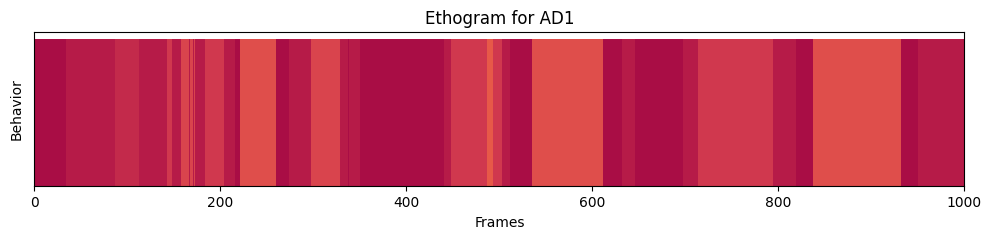

In [28]:
index_info_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/index_info_leaf.csv'

min_cluster_size=500 


# AD1
sourcefile_AD=['4fused35_240919_142556_1440_1080.csv']

ad1_clusterlabels = load_cluster_labels(index_info_path, sourcefile_AD, min_cluster_size)

create_ethogram(ad1_clusterlabels[14500:15500], 'AD1', output_path=None)

# sourcefile_WT=['4fused36_240919_155226_1440_1080.csv']

# wt1_clusterlabels = load_cluster_labels(index_info_path, sourcefile_WT, min_cluster_size)
# create_ethogram(wt1_clusterlabels[:18000], 'WT1', output_path=None)

### TRANSITION PROBABILITY

##### calculate transition probability

In [4]:
### CALCULATE TRANSITON PROBABILITY ###########
def calculate_transition_matrix(labels, n_clusters, tau=1):
    # Remove noise (-1) labels and merge consecutive identical clusters
    valid_labels = labels[labels != -1].values  # Series를 numpy 배열로 변환
    unique_labels = [valid_labels[0]]
    
    for i in range(1, len(valid_labels)):
        if valid_labels[i] != valid_labels[i - 1]:
            unique_labels.append(valid_labels[i])
    
    # Adjust labels to be zero-indexed
    unique_labels = np.array(unique_labels) - 1
    
    # Initialize the transition matrix
    transition_matrix = np.zeros((n_clusters, n_clusters))

    # Calculate the frequency of transitions for each tau
    for i in range(len(unique_labels) - tau):
        prev = unique_labels[i]
        next_ = unique_labels[i + tau]
        transition_matrix[prev, next_] += 1

    # Normalize to get the probability matrix for tau
    # row_sums = transition_matrix.sum(axis=1, keepdims=True)
    # transition_matrix = np.divide(
    #     transition_matrix,
    #     row_sums,
    #     where=(row_sums != 0),  # 0이 아닌 곳에서만 나눗셈 수행
    # )
    # # row_sums를 1D 배열로 변환
    # row_sums = row_sums.flatten()
    # # 행별로 부울 인덱싱 적용
    # transition_matrix[row_sums == 0, :] = 0

    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

    # Check for NaN or Inf values
    # check_finite(transition_matrix)

    # Clean the matrix (if necessary)
    transition_matrix_cleaned = clean_matrix(transition_matrix)

    return transition_matrix, transition_matrix_cleaned

def check_finite(matrix):
    """행렬에 NaN 또는 inf 값이 있는지 확인"""
    if np.any(np.isnan(matrix)):
        print("Warning: Matrix contains NaN values.")
    if np.any(np.isinf(matrix)):
        print("Warning: Matrix contains inf values.")

def clean_matrix(matrix):
    """결측값(NaN) 및 무한대(inf) 값을 0으로 대체"""
    matrix = np.nan_to_num(matrix, nan=0.0, posinf=0.0, neginf=0.0)
    #print("Replace the NaN or inf values into 0 ")
    return matrix

##### plot transition map

In [5]:
def plot_transition_map(transition_matrix, agglomerative = False, title = None):
    
    if agglomerative:
        # Perform agglomerative clustering 
        linkage_matrix = linkage(transition_matrix, method='centroid') # ward, single, complete, average, centroid
        order = leaves_list(linkage_matrix)  # get leaf ordering from clustering

        # Reorder the matrix
        transition_matrix = transition_matrix[order, :][:, order]
    
    plt.figure(figsize=(12, 10))
    
    # 히트맵 스타일을 조정해 시각적으로 더 눈에 띄게 만들기
    sns.heatmap(
        transition_matrix, 
        annot=False, fmt=".2f", 
        #cmap='viridis',  # 다양한 색상을 가진 'viridis' cmap 사용
        alpha=0.9,
        #linewidths=0.01, linecolor='gray',  # 구분선을 추가해 가독성 높이기
        square=True,  # 정사각형 셀 사용
        cmap='cividis',  
        # cmap: Blues, Reds, Greems/ viridis/ cividis/ coolwarm/magma, plasma/YlGnBu,PuBuGn
        #vmin=0.1, vmax=1,  # 낮은 값의 색을 더 옅게 하고, 높은 값은 더 짙게
        cbar_kws={'shrink': 0.8, 'label': 'Transition Probability'}  # 컬러바 크기 및 라벨 추가
    )

    # 외곽선 추가
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

    # 라벨 및 제목 추가
    plt.xlabel('Next Cluster')
    plt.ylabel('Previous Cluster')
    plt.title(f'Enhanced Transition Probability Map. {title or ""} \n agglomerative: {agglomerative}')
    
    plt.show()

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_transition_map2(transition_matrix, agglomerative=False, title=None, 
                         vmin=None, vmax=None, cmap='cividis', scaling=None, power_exponent=2):
    '''
    cmap : viridis, cividis, plasma, magma, YlGnBu, coolwarm
    scaling : 'log1p', 'arctan', or 'power' 'sigmoid' 'sqrt' (apply different transformations)
    power_exponent : Exponent for power scaling (default 2).
    '''
    if agglomerative:
        # Perform agglomerative clustering 
        linkage_matrix = linkage(transition_matrix, method='centroid')  # 'ward', 'single', 'complete', 'average'
        order = leaves_list(linkage_matrix)  # Get leaf ordering from clustering

        # Reorder the matrix
        transition_matrix = transition_matrix[order, :][:, order]
    
    # Apply scaling transformations if needed
    if scaling == 'log1p':
        transition_matrix = np.log1p(transition_matrix)  # Apply log(1 + x) transformation
        if vmin is not None:
            vmin = np.log1p(vmin)
        if vmax is not None:
            vmax = np.log1p(vmax)

    elif scaling == 'arctan':
        transition_matrix = np.arctan(transition_matrix)  # Apply arctan transformation
        if vmin is not None:
            vmin = np.arctan(vmin)
        if vmax is not None:
            vmax = np.arctan(vmax)

    elif scaling == 'power':
        transition_matrix = np.power(transition_matrix, power_exponent)  # Apply power transformation
        if vmin is not None:
            vmin = np.power(vmin, power_exponent)
        if vmax is not None:
            vmax = np.power(vmax, power_exponent)
    
    elif scaling == 'sigmoid':
        transition_matrix = 1/(1+np.exp(-transition_matrix))
        if vmin is not None:
            vmin = 1/(1+np.exp(-vmin))
        if vmax is not None:
            vmax = 1/(1+np.exp(-vmax))
    
    elif scaling == 'sqrt':
        transition_matrix = np.sqrt(transition_matrix)
        if vmin is not None:
            vmin = np.sqrt(vmin)
        if vmax is not None:
            vmax = np.sqrt(vmax)

    plt.figure(figsize=(12, 10))

    if vmin is None or vmax is None:
        # Apply default heatmap style if vmin/vmax are None
        sns.heatmap(
            transition_matrix, 
            annot=False, fmt=".2f", 
            cmap=cmap,  # color palette
            alpha=0.9,
            square=True,  # square cells
            cbar_kws={'shrink': 0.8, 'label': f'Transition Probability ({scaling} scale)'}  # color bar with label
        )
    else:
        # Apply fixed vmin/vmax if provided
        sns.heatmap(
            transition_matrix, 
            annot=False, fmt=".2f", 
            cmap=cmap,  # color palette
            alpha=0.9,
            square=True,  # square cells
            vmin=vmin, vmax=vmax,  # fixed color scale
            cbar_kws={'shrink': 0.8, 'label': f'Transition Probability ({scaling} scale)'}  # color bar with label
        )

    # Add borders around the plot
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

    # Add labels and title
    plt.xlabel('Next Cluster')
    plt.ylabel('Previous Cluster')
    plt.title(f'Enhanced Transition Probability Map. {title or ""} \n agglomerative: {agglomerative}')
    
    plt.show()


In [7]:
def plot_transition_map2(transition_matrix, agglomerative=False, title=None, 
                         vmin=None, vmax=None, cmap = 'cividis', scaling=None):
    '''
    cmap : viridis, cividis, plasma, magma, YlGnBu, coolwarm
    scaling : 'log1p' or None (apply log transformation to better visualize small probabilities)

    '''
    if agglomerative:
        # Perform agglomerative clustering 
        linkage_matrix = linkage(transition_matrix, method='centroid')  # 'ward', 'single', 'complete', 'average'
        order = leaves_list(linkage_matrix)  # Get leaf ordering from clustering

        # Reorder the matrix
        transition_matrix = transition_matrix[order, :][:, order]
    
    # Apply scaling (log transformation if needed)
    if scaling == 'log1p':
        transition_matrix = np.log1p(transition_matrix)  # Apply log(1 + x) transformation
        vmin = np.log1p(vmin) if vmin is not None else None
        vmax = np.log1p(vmax) if vmax is not None else None

        plt.figure(figsize=(12, 10))

        if vmin is None or vmax is None:
            # 히트맵 스타일을 조정해 시각적으로 더 눈에 띄게 만들기
            sns.heatmap(
                transition_matrix, 
                annot=False, fmt=".2f", 
                cmap=cmap,  # 기본 팔레트
                alpha=0.9,
                square=True,  # 정사각형 셀 사용
                cbar_kws={'shrink': 0.8, 'label': 'Transition Probability(log scale)'}  # 컬러바 크기 및 라벨 추가
            )
        else:
            # 히트맵 스타일을 조정해 시각적으로 더 눈에 띄게 만들기
            sns.heatmap(
                transition_matrix, 
                annot=False, fmt=".2f", 
                cmap=cmap,  # 기본 팔레트
                alpha=0.9,
                square=True,  # 정사각형 셀 사용
                vmin=vmin, vmax=vmax,  # 범위 고정
                cbar_kws={'shrink': 0.8, 'label': 'Transition Probability(log scale)'}  # 컬러바 크기 및 라벨 추가
            )
    else:
        plt.figure(figsize=(12, 10))
        
        # 히트맵 스타일을 조정해 시각적으로 더 눈에 띄게 만들기
        sns.heatmap(
            transition_matrix, 
            annot=False, fmt=".2f", 
            cmap=cmap,  # 기본 팔레트
            alpha=0.9,
            square=True,  # 정사각형 셀 사용
            vmin=vmin, vmax=vmax,  # 범위 고정
            cbar_kws={'shrink': 0.8, 'label': 'Transition Probability'}  # 컬러바 크기 및 라벨 추가
        )

    # 외곽선 추가
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

    # 라벨 및 제목 추가
    plt.xlabel('Next Cluster')
    plt.ylabel('Previous Cluster')
    plt.title(f'Enhanced Transition Probability Map. {title or ""} \n agglomerative: {agglomerative}')
    
    plt.show()


In [8]:
def plot_difference_transition_map(matrix1, matrix2, threshold=0, agglomerative = False, title = None):
    # 두 전환 행렬의 차이 계산
    difference_matrix = matrix2 - matrix1

    if agglomerative:
        # Perform agglomerative clustering to reorder the matrix
        linkage_matrix = linkage(abs(difference_matrix), method='centroid')
        order = leaves_list(linkage_matrix)  # get leaf ordering from clustering

        # Reorder the matrix
        difference_matrix = difference_matrix[order, :][:, order]

    # 차이 절댓값 기준으로 강조
    highlighted_matrix = np.where(np.abs(difference_matrix) > threshold, difference_matrix, 0)

    plt.figure(figsize=(12, 10))
    
    # 히트맵으로 차이 행렬 시각화
    sns.heatmap(
        highlighted_matrix, 
        annot=False, fmt=".2f", 
        cmap='bwr',  # # cmap: Blues, Reds, Greems/ viridis/ cividis/ coolwarm/magma, plasma/YlGnBu,PuBuGn
        #cmap = 'cividis',
        center=0,  # 0을 중간으로 설정해 양수와 음수 값의 차이를 강조
        cbar_kws={'shrink': 0.8, 'label': 'Transition Probability Difference'}
    )

    # 외곽선 추가
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

    plt.xlabel('Next Cluster')
    plt.ylabel('Previous Cluster')
    plt.title(f'Difference in Transition Probability Maps. {title or ""} \n agglomerative: {agglomerative}')
    plt.show()

### EIGENVALUE DECOMPOSITION

##### calculate eigenvalues

In [9]:
def compute_transition_matrices_and_eigenvalues(labels_list, n_clusters, tau_list):
    """
    Compute transition matrices and eigenvalues for each individual in labels_list
    for each tau value in tau_list.
    
    Args:
        labels_list (list of pd.Series): List of cluster labels for each individual.
        n_clusters (int): Number of clusters.
        tau_list (list of int): List of tau values for which to calculate transition matrices and eigenvalues.

    Returns:
        transition_dict: Dictionary with tau values as keys and lists of transition matrices for each individual as values.
        eigenvalues_dict: Dictionary with tau values as keys and lists of eigenvalues for each individual as values.
        eigenvalues_abs_dict: Dictionary with tau values as keys and lists of absolute eigenvalues for each individual as values.
    """
    # Initialize dictionaries to store transition matrices and eigenvalues for each tau
    transition_dict = {tau: [] for tau in tau_list}
    eigenvalues_dict =  {tau: [] for tau in tau_list}
    eigenvalues_abs_dict = {tau: [] for tau in tau_list}
    
    # Iterate over each individual's labels
    for labels in labels_list:        
        # Compute transition matrix and eigenvalues for each tau value
        for tau in tau_list:
            transition_matrix, transition_matrix_cleaned = calculate_transition_matrix(labels, n_clusters, tau)
            transition_dict[tau].append(transition_matrix_cleaned)
            
            # Compute eigenvalues and sort them in descending order 
            eigenvalues = np.linalg.eigvals(transition_matrix_cleaned)
            eigenvalues_sorted = np.sort(eigenvalues)[::-1] # Sort eigenvalues in descending order
            eigenvalues_abs_sorted = np.sort(np.abs(eigenvalues))[::-1] # Sort absolute eigenvalues in descending order
            eigenvalues_dict[tau].append(eigenvalues_sorted)
            eigenvalues_abs_dict[tau].append(eigenvalues_abs_sorted)
    
    return transition_dict, eigenvalues_dict, eigenvalues_abs_dict

##### calculate eig mean and sem

In [10]:
def calculate_eigenvalue_means_and_sems(eigenvalues_dict, tau_list):
    """
    Calculate the mean and SEM of eigenvalues for each tau value.
    
    Args:
        eigenvalues_dict (dict): Dictionary containing eigenvalues for each tau value.
        tau_list (list of int): List of tau values for which to calculate the means and SEMs.
    
    Returns:
        tuple: A tuple containing two lists:
            - eigenvalue_means: List of means for each tau value (shape: len(tau_list) x len(eigenvalues)).
            - eigenvalue_sems: List of SEMs for each tau value (shape: len(tau_list) x len(eigenvalues)).
    """
    eigenvalue_means = []
    eigenvalue_sems = []

    # Calculate means and SEMs for each tau value
    for tau in tau_list:
        tau_eigenvalues = np.array(eigenvalues_dict[tau])
        # Calculate the mean of eigenvalues for each tau
        tau_means = np.mean(tau_eigenvalues, axis=0)
        # Calculate the SEM (standard error of the mean) for each eigenvalue
        tau_sems = np.std(tau_eigenvalues, axis=0) / np.sqrt(len(eigenvalues_dict[tau]))
        
        eigenvalue_means.append(tau_means)
        eigenvalue_sems.append(tau_sems)

    return eigenvalue_means, eigenvalue_sems

### MARKOVIAN PROCESS

##### calculate markovian model prediction and noise floor

In [11]:
def calculate_markov_model_prediction(initial_eigenvalues, tau_list):
    """
    Calculate the Markov model prediction using the eigenvalues of the initial transition matrix 
    raised to the power of each tau, and compute decay rates for each tau.

    Args:
        initial_eigenvalues (np.ndarray): The eigenvalues for tau=1. This is directly input from the transition matrix at tau=1.
        tau_list (list): A list of tau values for which to calculate the predictions.

    Returns:
        np.ndarray: An array of predicted eigenvalues for each tau in tau_list.
        np.ndarray: An array of decay rates for each tau in tau_list.
        float: The second largest eigenvalue for tau=1.
        float: The decay time 
    """
 
    # Extract the second largest eigenvalue for tau=1
    lambda_2_1 = np.sort(np.abs(initial_eigenvalues))[-2]  # |λ₂(1)| for tau=1

    # Calculate the decay time_2 for tau=1 based on λ₂(1)
    decay_time_2 = -1 / np.log(lambda_2_1)  # Calculate it, using the formula from the paper
    
    # For each tau, calculate the eigenvalues for the predicted matrix
    markov_model_prediction = []
    decay_rates = []
    for tau in tau_list:
        # Calculate the tau-th eigenvalues for the Markov model (exponentially decaying)
        predicted_eigenvalues = initial_eigenvalues ** tau  # # This follows T_M(tau) = [T(1)]^tau
        markov_model_prediction.append(np.abs(predicted_eigenvalues))

        # Calculate decay rate for each eigenvalue at this tau
        #predicted_eigenvalues = np.clip(predicted_eigenvalues, 1e-10, None)  # 0을 작은 값(1e-10)으로 치환

        decay_rate = -np.log(np.abs(predicted_eigenvalues)) / tau
        decay_rates.append(decay_rate)

    return markov_model_prediction, decay_rates, lambda_2_1, decay_time_2

def calculate_noise_floor(labels_list, n_clusters, tau_list, eigenvalues_index=1, num_shuffles=10):
    """
    Calculate the noise floor for each tau by repeatedly shuffling the labels_list and computing
    the eigenvalue corresponding to the specified index for each tau.

    Args:
        labels_list (list of pandas.Series): List of cluster labels for each individual.
        n_clusters (int): Number of clusters.
        tau_list (list of int): List of tau values.
        eigenvalues_index (int): Index of the eigenvalue to use for the noise floor (usually the second eigenvalue).
        num_shuffles (int): Number of shuffles to perform to calculate a stable noise floor.

    Returns:
        dict: Dictionary with tau values as keys and averaged noise floor values for each tau.
    """
    noise_floor_dict = {tau: [] for tau in tau_list}

    for _ in range(num_shuffles):
        # Shuffle labels and compute eigenvalues for each shuffle
        shuffled_labels_list = [labels.sample(frac=1).reset_index(drop=True) for labels in labels_list]
        transition_dict, eigenvalues_dict, _ = compute_transition_matrices_and_eigenvalues(shuffled_labels_list, n_clusters, tau_list)

        # Collect the eigenvalues for the specified index for each tau
        for tau in tau_list:
            shuffled_eigenvalues = [np.abs(eigenvalues_dict[tau][i][eigenvalues_index]) for i in range(len(shuffled_labels_list))]
            noise_floor_dict[tau].append(np.mean(shuffled_eigenvalues))

    # Average over all shuffles for each tau to get a stable noise floor
    noise_floor_dict = {tau: np.mean(values) for tau, values in noise_floor_dict.items()}

    return noise_floor_dict

##### Long time scale transition matrices and non-Markovian dynamics.

In [12]:
def plot_longtime_transition_matrices(labels_list, n_clusters, tau_list, mu_list):
    """
    Plots the absolute values of the leading eigenvalues of the transition matrices as a function of τ.
    The plot includes the average eigenvalue with standard error, Markov model prediction, and noise floor.

    Args:
        labels_list (pandas.Series): The cluster labels for each time point.
        n_clusters (int): The number of clusters.
        tau_list (list or np.ndarray): List or array of time scales (τ).
        mu_list (list or np.ndarray): List or array of 'mu' values for which the plot is generated.
    """
    transition_dict, eigenvalues_dict, eigenvalues_abs_dict = compute_transition_matrices_and_eigenvalues(labels_list, n_clusters, tau_list)
    eigenvalue_means, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_abs_dict, tau_list)

    # Markov model prediction (assumed exponential decay of eigenvalues)
    markov_model_prediction, decay_rates, lambda_2_1, decay_time_2 = calculate_markov_model_prediction(eigenvalue_means[0], tau_list)

    # Noise floor (assumed: second largest eigenvalue from random temporal shuffling)
    noise_floor_dict = calculate_noise_floor(labels_list, n_clusters, tau_list, eigenvalues_index=1)
    # 수렴값 계산: 큰 타우에서 평균값 사용
    large_tau_values = tau_list[-5:]  # 마지막 5개의 타우 선택
    converged_noise_floor = np.mean([noise_floor_dict[tau] for tau in large_tau_values])

    # Plotting
    plt.figure(figsize=(8, 6))

    # Color map to ensure same color for each mu value
    colors = plt.cm.viridis(np.linspace(0, 1, len(mu_list)))

    for mu_idx, mu in enumerate(mu_list):  # Plot for each mu value
        color = colors[mu_idx]  # Set color for this mu
        
        # Plot actual eigenvalue mean with SEM as a filled area
        plt.plot(tau_list, [eigenvalue_means[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                 color=color, linestyle='-', label=f"μ={mu}")
        
        # Add confidence intervals using SEM
        plt.fill_between(tau_list, 
                         [eigenvalue_means[tau_idx][mu-1] - eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                         [eigenvalue_means[tau_idx][mu-1] + eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                         color=color, alpha=0.1)

        # Plot Markov model prediction as dashed line
        plt.plot(tau_list, [markov_model_prediction[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                 color=color, linestyle='--')

    # Add noise floor as a dotted line
    plt.axhline(y=converged_noise_floor, color='k', linestyle=':', label="Noise floor (converged)")
    #plt.plot(tau_list, [noise_floor_dict[tau] for tau in tau_list], 'k:', label="Noise floor")

    # Customize the plot with logarithmic x-axis
    plt.xscale('log')
    plt.xlim([tau_list[0], tau_list[-1]])
    plt.ylim([0,1])
    plt.xlabel("Number of transitions (τ)")
    plt.ylabel("Absolute value of eigenvalues (|λ|)")
    plt.title("Absolute values of the leading eigenvalues of the transition matrices as a function of τ")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eigenvalues_abs_dict, eigenvalue_means, eigenvalue_sems

In [13]:
def plot_longtime_transition_matrices_test(labels_list, n_clusters, tau_list, mu_list, k_list):
    """
    Plots the absolute values of the leading eigenvalues of the transition matrices as a function of τ.
    The plot includes the average eigenvalue with standard error, Markov model prediction, and noise floor.

    Args:
        labels_list (pandas.Series): The cluster labels for each time point.
        n_clusters (int): The number of clusters.
        tau_list (list or np.ndarray): List or array of time scales (τ).
        mu_list (list or np.ndarray): List or array of 'mu' values for which the plot is generated.
    """
    if len(mu_list) != len(k_list):
        raise ValueError("The length of mu_list and k_list must be the same.")

    transition_dict, eigenvalues_dict, eigenvalues_abs_dict = compute_transition_matrices_and_eigenvalues(labels_list, n_clusters, tau_list)
    eigenvalue_means, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_abs_dict, tau_list)

    # Markov model prediction (assumed exponential decay of eigenvalues)
   # markov_model_prediction, decay_rates, lambda_2_1, decay_time_2 = calculate_markov_model_prediction(eigenvalue_means[0], tau_list)

    # Noise floor (assumed: second largest eigenvalue from random temporal shuffling)
    noise_floor_dict = calculate_noise_floor(labels_list, n_clusters, tau_list, eigenvalues_index=1)
    # 수렴값 계산: 큰 타우에서 평균값 사용
    large_tau_values = tau_list[-200:]  # 마지막 5개의 타우 선택
    converged_noise_floor = np.mean([noise_floor_dict[tau] for tau in large_tau_values])

    # Plotting
    plt.figure(figsize=(8, 6))

    # Color map to ensure same color for each mu value
    colors = plt.cm.viridis(np.linspace(0, 1, len(mu_list)))

    for mu_idx, mu in enumerate(mu_list):  # Plot for each mu value
        color = colors[mu_idx]  # Set color for this mu
        
        # Plot actual eigenvalue mean with SEM as a filled area
        plt.plot(tau_list, [eigenvalue_means[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                 color=color, linestyle='-', label=f"μ={mu}")
        
        # Add confidence intervals using SEM
        plt.fill_between(tau_list, 
                         [eigenvalue_means[tau_idx][mu-1] - eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                         [eigenvalue_means[tau_idx][mu-1] + eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                         color=color, alpha=0.1)
        # Plot vertical line at x = k for this mu
        if mu_idx < 2 : 
            plt.axvline(x=k_list[mu_idx], color=color, linestyle='--', linewidth=1) 

        # Plot Markov model prediction as dashed line
        #plt.plot(tau_list, [markov_model_prediction[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
        #         color=color, linestyle='--')

    # Add noise floor as a dotted line
    #plt.axhline(y=converged_noise_floor, color='k', linestyle=':', label="Noise floor (converged)")
    #plt.plot(tau_list, [noise_floor_dict[tau] for tau in tau_list], 'k:', label="Noise floor")

    # Customize the plot with logarithmic x-axis
    plt.xscale('log')
    plt.xlim([tau_list[0], tau_list[-1]])
    plt.ylim([0,1])
    plt.xlabel("Number of transitions (τ)")
    plt.ylabel("Absolute value of eigenvalues (|λ|)")
    plt.title("Absolute values of the leading eigenvalues of the transition matrices as a function of τ")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eigenvalues_abs_dict, eigenvalue_means, eigenvalue_sems

In [14]:
def plot_longtime_transition_matrices2(labels_list, n_clusters, tau_list, mu_list):
    """
    Plots the absolute values of the leading eigenvalues of the transition matrices as a function of τ.
    The plot includes the average eigenvalue with standard error, Markov model prediction, and noise floor.

    Args:
        labels_list (pandas.Series): The cluster labels for each time point.
        n_clusters (int): The number of clusters.
        tau_list (list or np.ndarray): List or array of time scales (τ).
        mu_list (list or np.ndarray): List or array of 'mu' values for which the plot is generated.
    """
    transition_dict, eigenvalues_dict, eigenvalues_abs_dict = compute_transition_matrices_and_eigenvalues(labels_list, n_clusters, tau_list)
    eigenvalue_means, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_abs_dict, tau_list)

    # Markov model prediction (assumed exponential decay of eigenvalues)
    markov_model_prediction, decay_rates, lambda_2_1, decay_time_2 = calculate_markov_model_prediction(eigenvalue_means[0], tau_list)

    # Noise floor (assumed: second largest eigenvalue from random temporal shuffling)
    noise_floor_dict = calculate_noise_floor(labels_list, n_clusters, tau_list, eigenvalues_index=1)
    # 수렴값 계산: 큰 타우에서 평균값 사용
    #large_tau_values = tau_list[-5:]  # 마지막 5개의 타우 선택
    #converged_noise_floor = np.mean([noise_floor_dict[tau] for tau in large_tau_values])

    # Plotting
    plt.figure(figsize=(8, 6))

    # Color map to ensure same color for each mu value
    colors = plt.cm.viridis(np.linspace(0, 1, len(mu_list)))
    
    # Define finer tau values for smooth plotting
    tau_fine = np.linspace(tau_list[0], tau_list[-1], 500)

    for mu_idx, mu in enumerate(mu_list):  # Plot for each mu value
        color = colors[mu_idx]  # Set color for this mu
        
        # Interpolate eigenvalue means and Markov model predictions for smooth lines
        eigenvalue_means_interp = interp1d(tau_list, [eigenvalue_means[tau_idx][mu-1] for tau_idx in range(len(tau_list))], kind='cubic')
        markov_model_prediction_interp = interp1d(tau_list, [markov_model_prediction[tau_idx][mu-1] for tau_idx in range(len(tau_list))], kind='cubic')
        
        # Plot actual eigenvalue mean with SEM as a filled area
        plt.plot(tau_fine, eigenvalue_means_interp(tau_fine), color=color, linestyle='-', label=f"μ={mu}")
        
        # Add confidence intervals using SEM (interpolated for smoothness)
        sem_lower = interp1d(tau_list, 
                             [eigenvalue_means[tau_idx][mu-1] - eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                             kind='cubic')
        sem_upper = interp1d(tau_list, 
                             [eigenvalue_means[tau_idx][mu-1] + eigenvalue_sems[tau_idx][mu-1] for tau_idx in range(len(tau_list))],
                             kind='cubic')
        
        plt.fill_between(tau_fine, sem_lower(tau_fine), sem_upper(tau_fine), color=color, alpha=0.1)

        # Plot Markov model prediction as dashed line
        plt.plot(tau_fine, markov_model_prediction_interp(tau_fine), color=color, linestyle='--')

    # Add noise floor as a dotted line (no need for interpolation since it’s a constant line across tau values)
    noise_floor_values = [noise_floor_dict[tau] for tau in tau_list]
    plt.plot(tau_list, noise_floor_values, 'k:', label="Noise floor")
    #plt.axhline(y=converged_noise_floor, color='k', linestyle=':', label="Noise floor (converged)")

    # Customize the plot with logarithmic x-axis starting from tau_list's first value
    plt.xscale('log')
    plt.xlim([tau_list[0], tau_list[-1]])
    plt.ylim([0,1])
    plt.xlabel("Number of transitions (τ)")
    plt.ylabel("Absolute value of eigenvalues (|λ|)")
    plt.title("Absolute values of the leading eigenvalues of the transition matrices as a function of τ")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eigenvalues_abs_dict, eigenvalue_means, eigenvalue_sems


### STATISTIC ANALYSIS

##### perform statistical test

In [15]:
### STATISTICAL HYPOTHESIS TEST #############################
def check_normality(data):
    """Tests for normality using the Shapiro-Wilk test"""
    stat, p_value = stats.shapiro(data)
    return p_value

def perform_tests(eigenvalues1, eigenvalues2, alpha=0.05):
    """
    Performs statistical tests to compare two sets of eigenvalues.
    Selects the appropriate test based on normality and prints the results.

    Args:
        eigenvalues1, eigenvalues2: Arrays of eigenvalues to compare.
        alpha: Significance level for normality test.

    Returns:
        test_type: The name of the chosen test (t-test or Mann-Whitney U).
        p_value_test1: The p-value from the chosen test.
        p_value_test2: The p-value from the Kolmogorov-Smirnov test.
    """

    # Check normality of each group using Shapiro-Wilk test
    p_value1 = check_normality(eigenvalues1)
    p_value2 = check_normality(eigenvalues2)
    
    print(f"\nEigenvalues 1 Normality P-value: {p_value1}")
    print(f"Eigenvalues 2 Normality P-value: {p_value2}")
       
    # Select appropriate test based on normality results
    test_type = None
    if p_value1 > alpha and p_value2 > alpha:
        # Both groups are normally distributed, use t-test
        print("Both groups are normally distributed. Performing t-test.")
        t_statistic, p_value_test1 = stats.ttest_ind(eigenvalues1, eigenvalues2)
        print(f"T-statistic (p-value): {p_value_test1}")
        test_type = 't_test'
    else:
        # One or both groups are not normally distributed, use Mann-Whitney U test
        print("One or both groups are not normally distributed. Performing Mann-Whitney U test.")
        u_statistic, p_value_test1 = stats.mannwhitneyu(eigenvalues1, eigenvalues2, alternative='two-sided')
        print(f"Mann-Whitney U Statistic (p-value): {p_value_test1}")
        test_type = 'u-test'

    # Kolmogorov-Smirnov test for distributional differences
    ks_statistic, p_value_test2 = stats.ks_2samp(eigenvalues1, eigenvalues2)
    print(f"KS Statistic (p-value): {p_value_test2}")

    return test_type, p_value_test1, p_value_test2

##### comparison between two eigenvalues

In [16]:
def compare_eigenvalues(eigenvalues1, eigenvalues2, title1, title2):
    """
    Compare two sets of eigenvalues by performing statistical tests and visualizing results.

    Args:
        eigenvalues1 (np.ndarray): Array of eigenvalues for the first group.
        eigenvalues2 (np.ndarray): Array of eigenvalues for the second group.
        title1 (str, optional): Title or label for the first group's eigenvalues.
        title2 (str, optional): Title or label for the second group's eigenvalues.

    Returns:
        None
    """
    # Perform statistical tests to compare the two sets of eigenvalues
    test_type, p_value_test1, p_value_test2 = perform_tests(eigenvalues1, eigenvalues2)

    # Sorting the eigenvalues in descending order
    sorted_indices1 = np.argsort(eigenvalues1)[::-1]
    sorted_indices2 = np.argsort(eigenvalues2)[::-1]
    
    sorted_eigenvalues1 = eigenvalues1[sorted_indices1]
    sorted_eigenvalues2 = eigenvalues2[sorted_indices2]

    # Plot the eigenvalues of both groups for comparison
    plt.figure(figsize=(12, 6))
    plt.plot(sorted_eigenvalues1, label=f'{title1 or "Group1"} Eigenvalues', marker='o')
    plt.plot(sorted_eigenvalues2, label=f'{title2 or "Group2"} Eigenvalues', marker='o')
    plt.title(f'Comparison of Eigenvalues {title1 or "Group1"} vs. {title2 or "Group2"} \n'
               f'{test_type} p-value: {p_value_test1:.3f} and KS test p-value: {p_value_test2:.3f}')
    plt.xlabel('Index (Sorted)')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()

### COMMAND

In [18]:
### LOAD DATA #########################################################################################

index_info_path = '/home/jiyoung/Desktop/lai_240524/Post-pose3D/result/newdebug2/index_info.csv'
n_clusters = 43
min_cluster_size=500 
#tau_list=[1,10,20,50,100,500,1000]

# AD 7m & 8m
sourcefile_AD=['4fused35_240626_124349_1440_1080.csv','4fused36_240919_211056_1440_1080.csv',
                  '4fused35_240919_162817_1440_1080.csv','4fused35_240919_170310_1440_1080.csv',
                  '4fused35_240919_173651_1440_1080.csv']
labels_AD_list = [load_cluster_labels(index_info_path, [sourcefile], min_cluster_size) for sourcefile in sourcefile_AD]

# WT 7m & 8m
sourcefile_WT=['4fused36_240919_200322_1440_1080.csv','4fused36_240919_203707_1440_1080.csv',
                  '4fused35_240919_142556_1440_1080.csv','4fused35_240919_150350_1440_1080.csv',
                  '4fused36_240919_155226_1440_1080.csv']
labels_WT_list = [load_cluster_labels(index_info_path, [sourcefile], min_cluster_size) for sourcefile in sourcefile_WT]

In [19]:
#tau_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,30,40,50,60,70,80,90,100,200,300,400,500,600,700]
num_tau = 1000
tau_list = list(range(1, num_tau+1)) # 1~num_tau

# AD
transition_dict_AD, eigenvalues_dict_AD, _ = compute_transition_matrices_and_eigenvalues(labels_AD_list, n_clusters, tau_list)
eigenvalue_means_AD, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_dict_AD, tau_list)

# WT
transition_dict_WT, eigenvalues_dict_WT, _ = compute_transition_matrices_and_eigenvalues(labels_WT_list, n_clusters, tau_list)
eigenvalue_means_WT, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_dict_WT, tau_list)

/tmp/ipykernel_3074167/2493311141.py:35: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


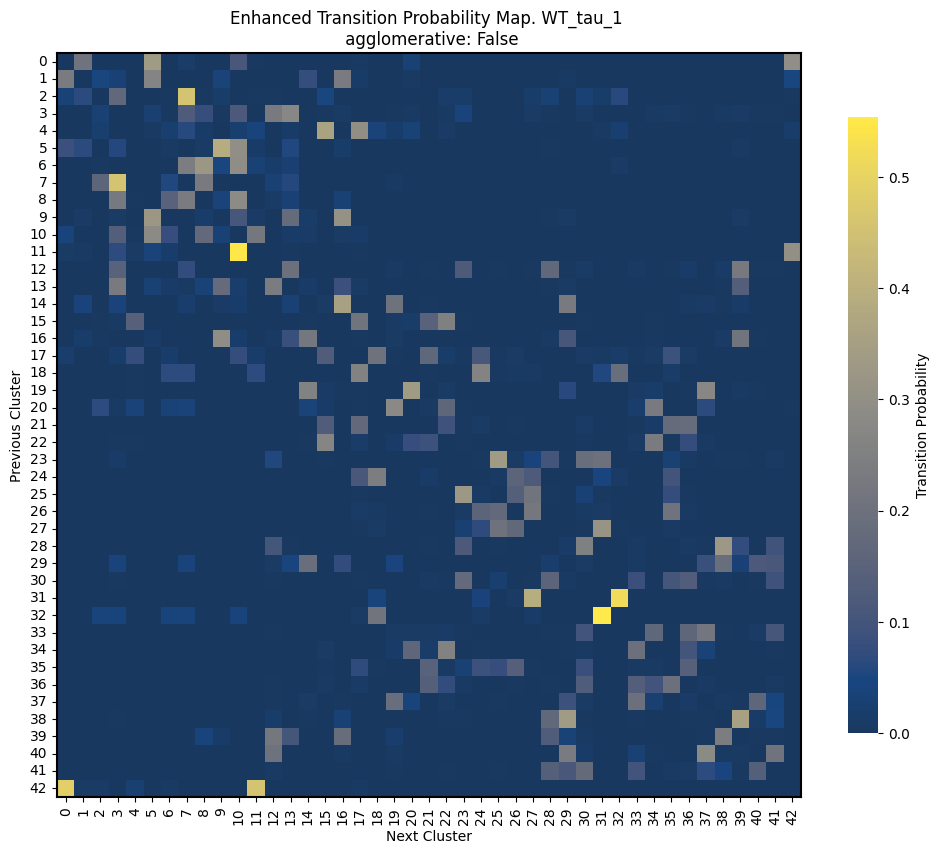

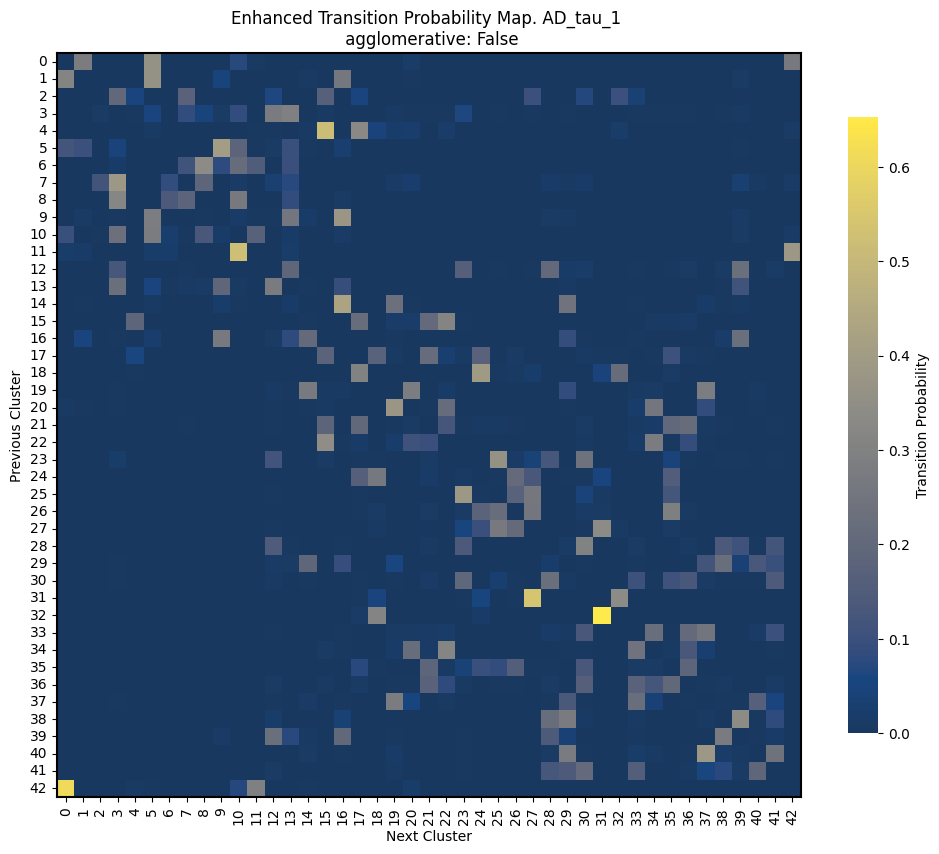

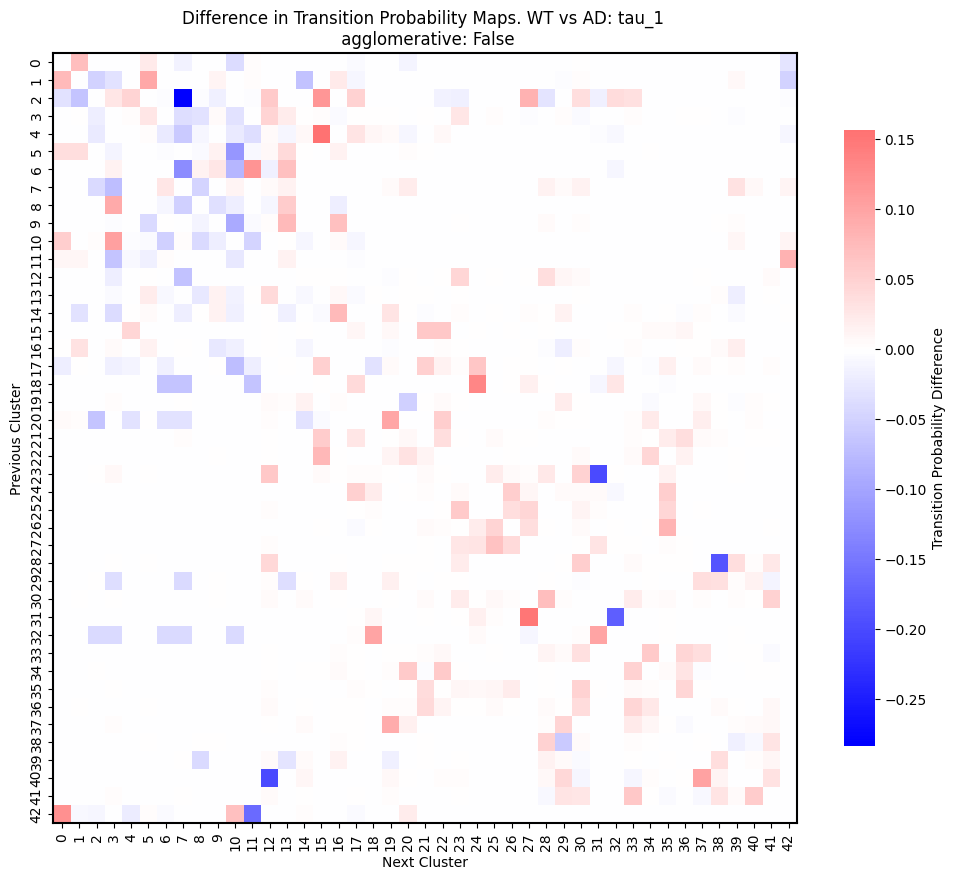

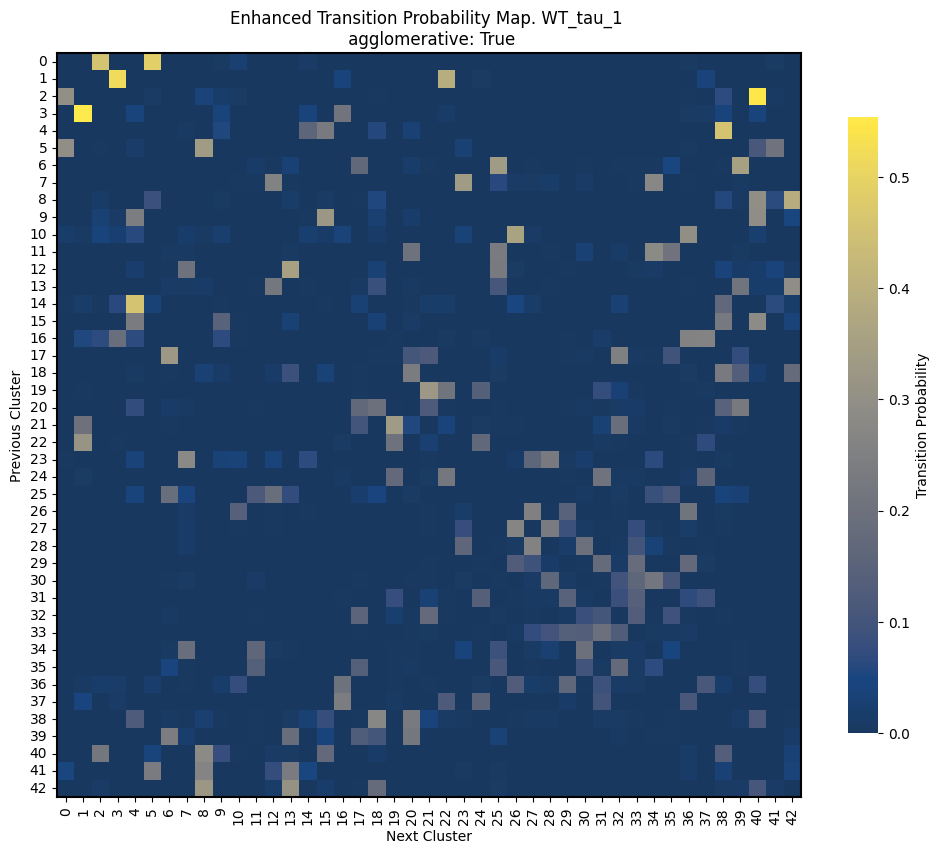

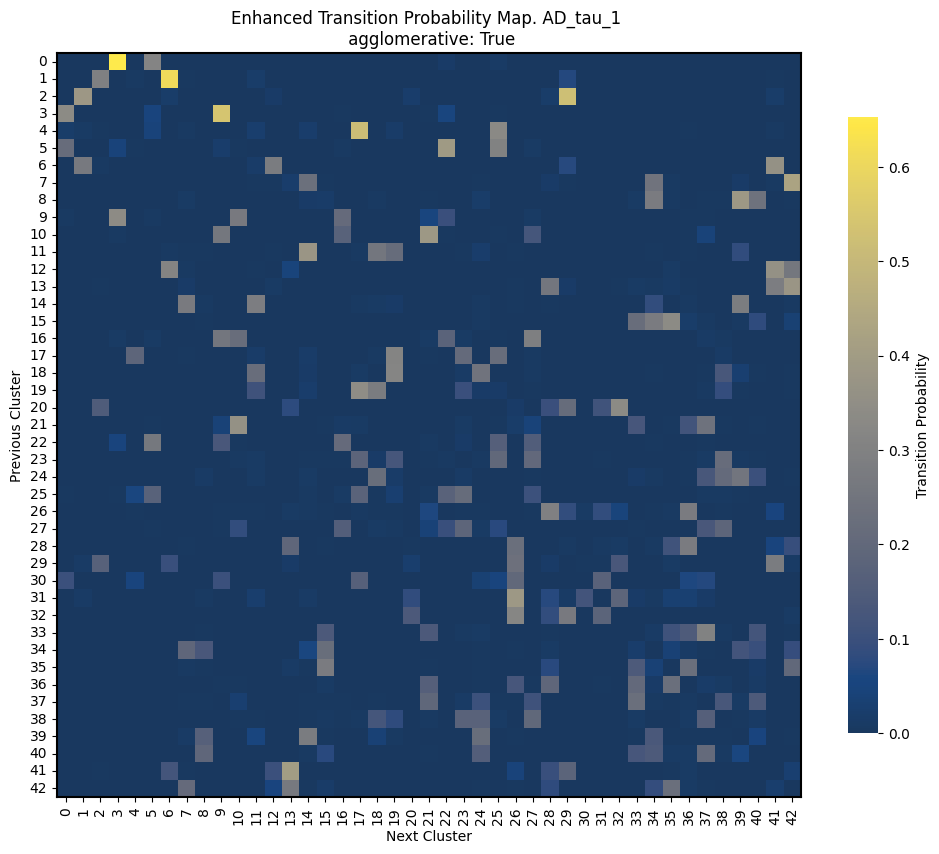

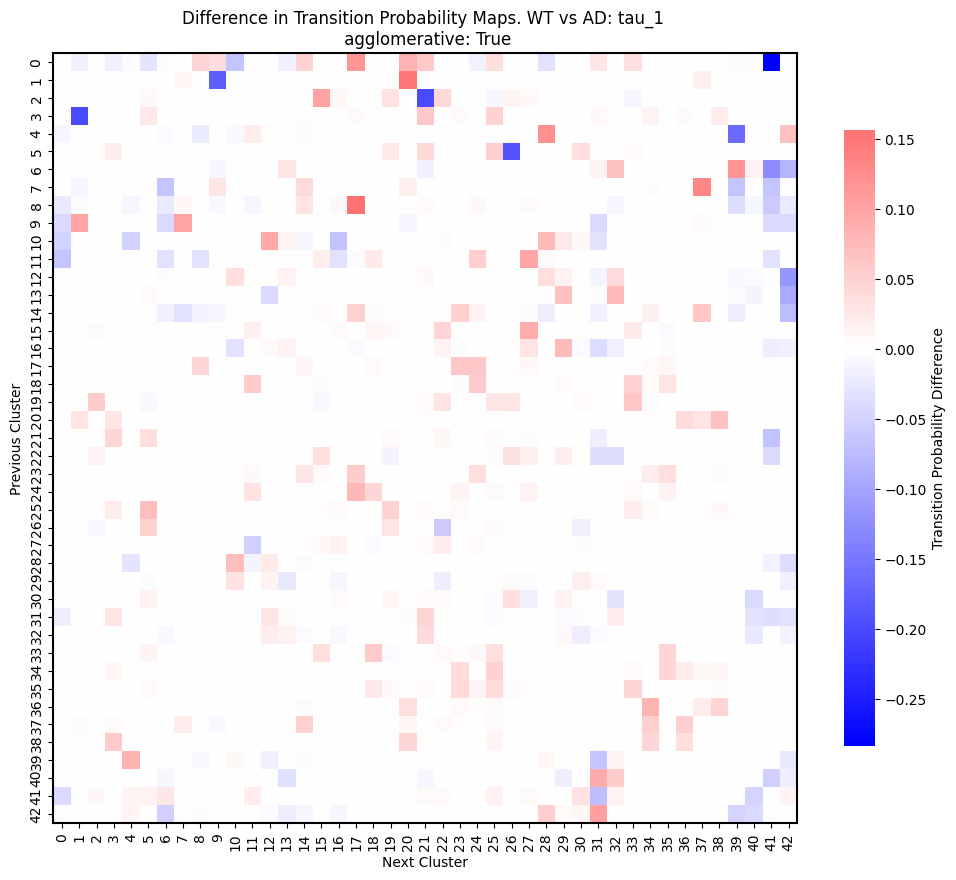

In [20]:
#### Plot Group Transition Map 
# Shape of "transition_dict_WT[tau_idx]" : (n, n_cluster, n_cluster)
# Shape of "np.mean(transition_dict_WT[tau_idx], axis=0)" : (n_cluster, n_cluster) it's group mean transition map
tau_idx = 1

plot_transition_map(np.mean(transition_dict_WT[tau_idx], axis=0), agglomerative = False, title = f'WT_tau_{tau_idx}')
plot_transition_map(np.mean(transition_dict_AD[tau_idx],axis=0), agglomerative = False, title = f'AD_tau_{tau_idx}')
plot_difference_transition_map(np.mean(transition_dict_WT[tau_idx], axis=0),np.mean(transition_dict_AD[tau_idx],axis=0), threshold=0, agglomerative = False, title = f'WT vs AD: tau_{tau_idx}')

plot_transition_map(np.mean(transition_dict_WT[tau_idx], axis=0), agglomerative = True, title = f'WT_tau_{tau_idx}')
plot_transition_map(np.mean(transition_dict_AD[tau_idx],axis=0), agglomerative = True, title = f'AD_tau_{tau_idx}')
plot_difference_transition_map(np.mean(transition_dict_WT[tau_idx], axis=0),np.mean(transition_dict_AD[tau_idx],axis=0), threshold=0, agglomerative = True, title = f'WT vs AD: tau_{tau_idx}')

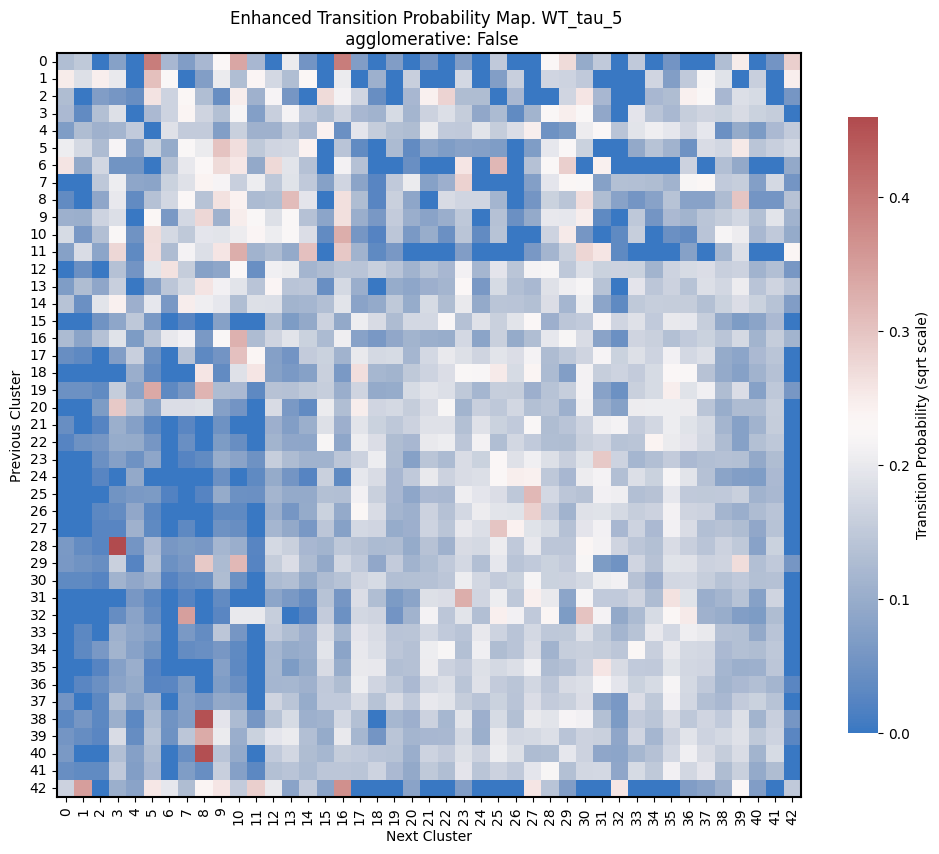

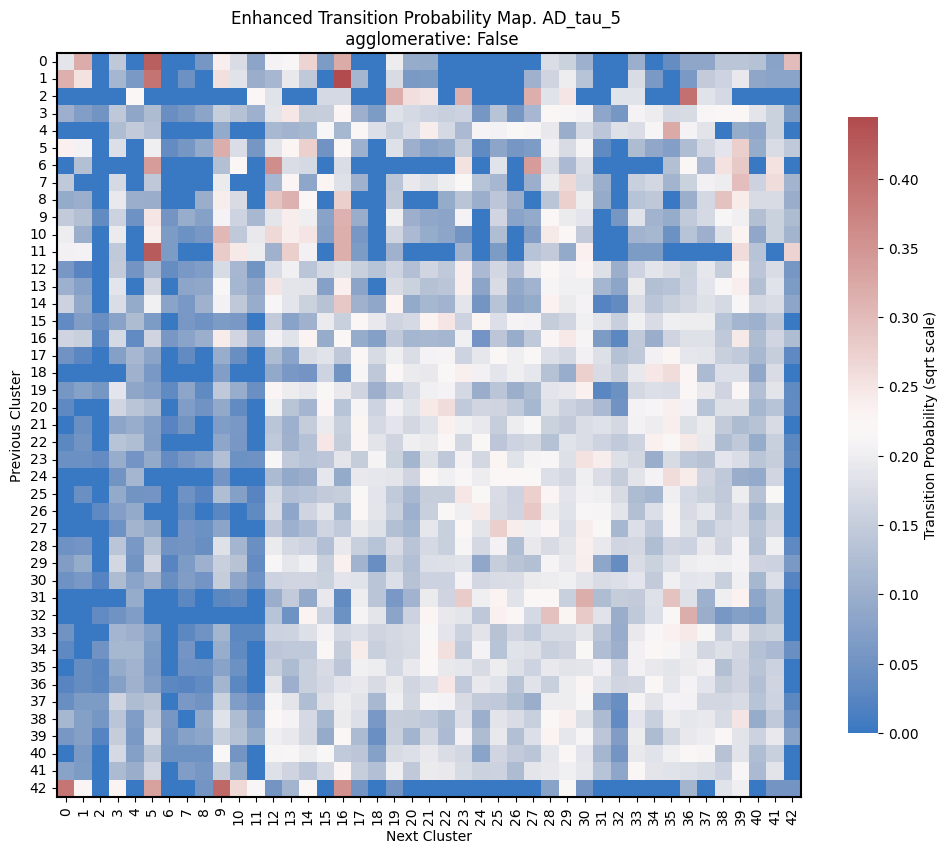

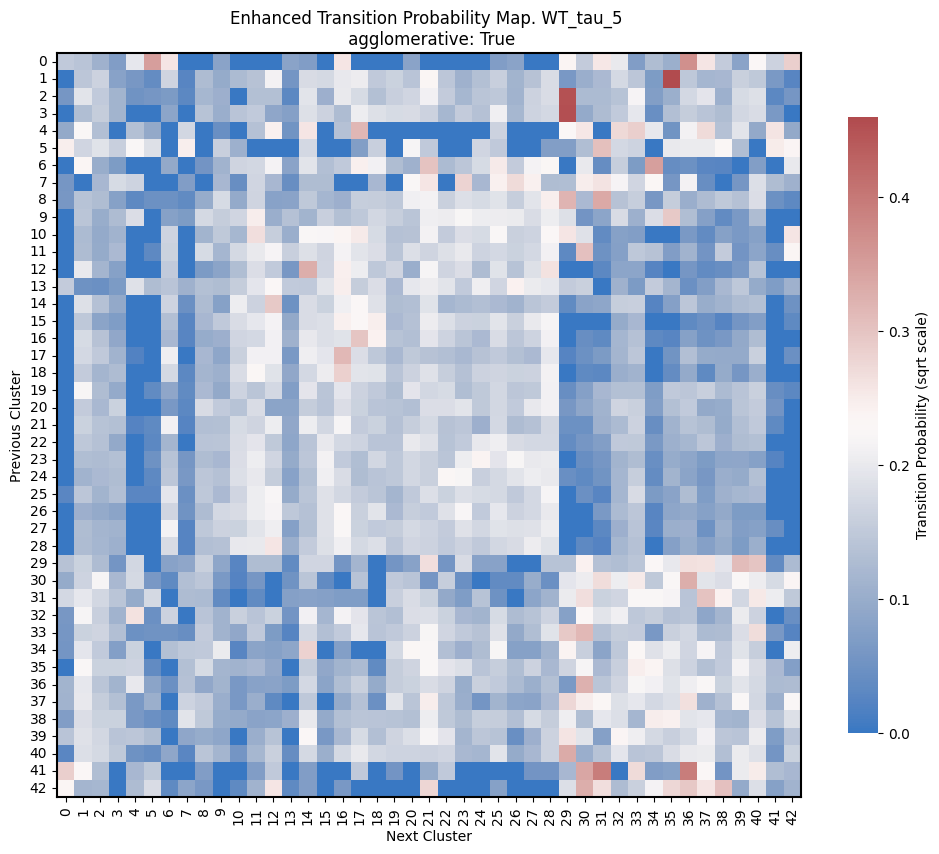

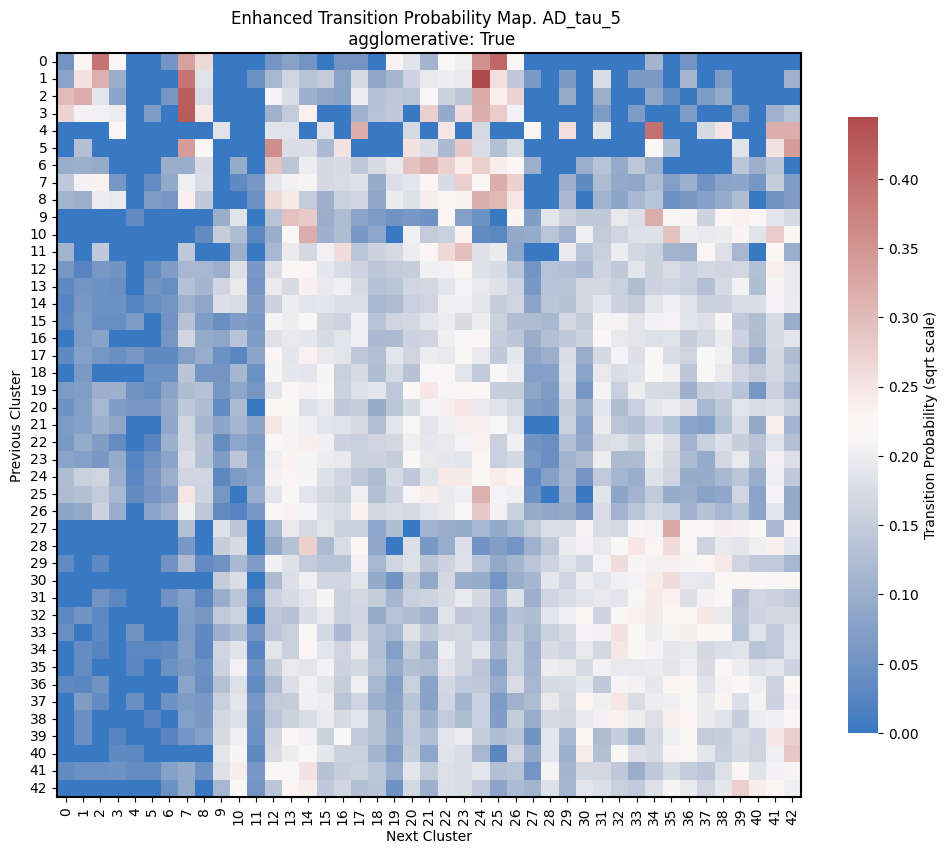

In [ ]:
tau_idx = 5
plot_transition_map2(np.mean(transition_dict_WT[tau_idx], axis=0), agglomerative = False, title = f'WT_tau_{tau_idx}',
                     cmap= 'vlag',scaling='sqrt')
plot_transition_map2(np.mean(transition_dict_AD[tau_idx],axis=0), agglomerative = False, title = f'AD_tau_{tau_idx}',
                     cmap= 'vlag',scaling='sqrt')
plot_transition_map2(np.mean(transition_dict_WT[tau_idx], axis=0), agglomerative = True, title = f'WT_tau_{tau_idx}',
                     cmap= 'vlag',scaling='sqrt')
plot_transition_map2(np.mean(transition_dict_AD[tau_idx],axis=0), agglomerative = True, title = f'AD_tau_{tau_idx}',
                     cmap= 'vlag',scaling='sqrt')



In [ ]:
compare_eigenvalues(eigenvalue_means_AD[0], eigenvalue_means_WT[0], 'AD_tau_1', 'WT_tau_1')
compare_eigenvalues(eigenvalue_means_AD[1], eigenvalue_means_WT[1], 'AD_tau_2', 'WT_tau_2')
compare_eigenvalues(eigenvalue_means_AD[2], eigenvalue_means_WT[2], 'AD_tau_3', 'WT_tau_3')
compare_eigenvalues(eigenvalue_means_AD[3], eigenvalue_means_WT[3], 'AD_tau_4', 'WT_tau_4')
compare_eigenvalues(eigenvalue_means_AD[4], eigenvalue_means_WT[4], 'AD_tau_5', 'WT_tau_5')
compare_eigenvalues(eigenvalue_means_AD[5], eigenvalue_means_WT[5], 'AD_tau_6', 'WT_tau_6')
compare_eigenvalues(eigenvalue_means_AD[6], eigenvalue_means_WT[6], 'AD_tau_7', 'WT_tau_7')
compare_eigenvalues(eigenvalue_means_AD[7], eigenvalue_means_WT[7], 'AD_tau_8', 'WT_tau_8')
compare_eigenvalues(eigenvalue_means_AD[8], eigenvalue_means_WT[8], 'AD_tau_9', 'WT_tau_9')
compare_eigenvalues(eigenvalue_means_AD[9], eigenvalue_means_WT[9], 'AD_tau_10', 'WT_tau_10')
compare_eigenvalues(eigenvalue_means_AD[10], eigenvalue_means_WT[10], 'AD_tau_11', 'WT_tau_11')
compare_eigenvalues(eigenvalue_means_AD[11], eigenvalue_means_WT[11], 'AD_tau_12', 'WT_tau_12')
compare_eigenvalues(eigenvalue_means_AD[12], eigenvalue_means_WT[12], 'AD_tau_13', 'WT_tau_13')
compare_eigenvalues(eigenvalue_means_AD[13], eigenvalue_means_WT[13], 'AD_tau_14', 'WT_tau_14')
compare_eigenvalues(eigenvalue_means_AD[14], eigenvalue_means_WT[14], 'AD_tau_15', 'WT_tau_15')
compare_eigenvalues(eigenvalue_means_AD[15], eigenvalue_means_WT[15], 'AD_tau_16', 'WT_tau_16')
compare_eigenvalues(eigenvalue_means_AD[16], eigenvalue_means_WT[16], 'AD_tau_17', 'WT_tau_17')
compare_eigenvalues(eigenvalue_means_AD[17], eigenvalue_means_WT[17], 'AD_tau_18', 'WT_tau_18')
compare_eigenvalues(eigenvalue_means_AD[18], eigenvalue_means_WT[18], 'AD_tau_19', 'WT_tau_19')
compare_eigenvalues(eigenvalue_means_AD[19], eigenvalue_means_WT[19], 'AD_tau_20', 'WT_tau_20')
compare_eigenvalues(eigenvalue_means_AD[20], eigenvalue_means_WT[20], 'AD_tau_21', 'WT_tau_21')
compare_eigenvalues(eigenvalue_means_AD[21], eigenvalue_means_WT[21], 'AD_tau_22', 'WT_tau_22')
compare_eigenvalues(eigenvalue_means_AD[22], eigenvalue_means_WT[22], 'AD_tau_23', 'WT_tau_23')
compare_eigenvalues(eigenvalue_means_AD[23], eigenvalue_means_WT[23], 'AD_tau_24', 'WT_tau_24')
compare_eigenvalues(eigenvalue_means_AD[24], eigenvalue_means_WT[24], 'AD_tau_30', 'WT_tau_30')
compare_eigenvalues(eigenvalue_means_AD[25], eigenvalue_means_WT[25], 'AD_tau_40', 'WT_tau_40')
compare_eigenvalues(eigenvalue_means_AD[26], eigenvalue_means_WT[26], 'AD_tau_50', 'WT_tau_50')
compare_eigenvalues(eigenvalue_means_AD[27], eigenvalue_means_WT[27], 'AD_tau_60', 'WT_tau_60')
compare_eigenvalues(eigenvalue_means_AD[28], eigenvalue_means_WT[28], 'AD_tau_70', 'WT_tau_70')
compare_eigenvalues(eigenvalue_means_AD[29], eigenvalue_means_WT[29], 'AD_tau_80', 'WT_tau_80')
compare_eigenvalues(eigenvalue_means_AD[30], eigenvalue_means_WT[30], 'AD_tau_90', 'WT_tau_90')
compare_eigenvalues(eigenvalue_means_AD[31], eigenvalue_means_WT[31], 'AD_tau_100', 'WT_tau_100')
compare_eigenvalues(eigenvalue_means_AD[32], eigenvalue_means_WT[32], 'AD_tau_200', 'WT_tau_200')
compare_eigenvalues(eigenvalue_means_AD[33], eigenvalue_means_WT[33], 'AD_tau_300', 'WT_tau_300')
compare_eigenvalues(eigenvalue_means_AD[34], eigenvalue_means_WT[34], 'AD_tau_400', 'WT_tau_400')
compare_eigenvalues(eigenvalue_means_AD[35], eigenvalue_means_WT[35], 'AD_tau_500', 'WT_tau_500')
compare_eigenvalues(eigenvalue_means_AD[36], eigenvalue_means_WT[36], 'AD_tau_600', 'WT_tau_600')
compare_eigenvalues(eigenvalue_means_AD[37], eigenvalue_means_WT[37], 'AD_tau_700', 'WT_tau_700')

/tmp/ipykernel_907621/2493311141.py:35: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_907621/3155650032.py:34: RuntimeWarning: divide by zero encountered in log
  decay_rate = -np.log(np.abs(predicted_eigenvalues)) / tau


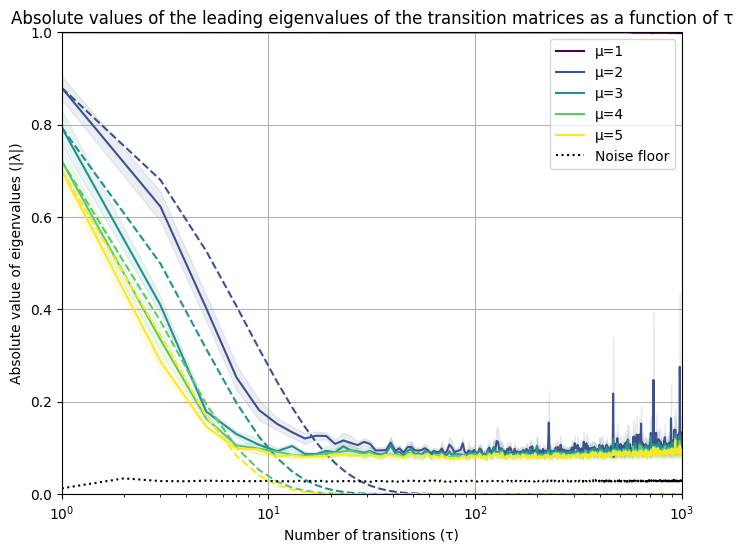

In [ ]:
tau_list = np.arange(1, 1001)  # Example tau values ## must include 1
mu_list = [1,2,3,4,5]  # Example mu values
eigenvalues_abs_WT_dict, eigenvalue_abs_WT_means, eigenvalue_abs_WT_sems = plot_longtime_transition_matrices2(labels_WT_list, n_clusters, tau_list, mu_list)

/tmp/ipykernel_907621/2493311141.py:35: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


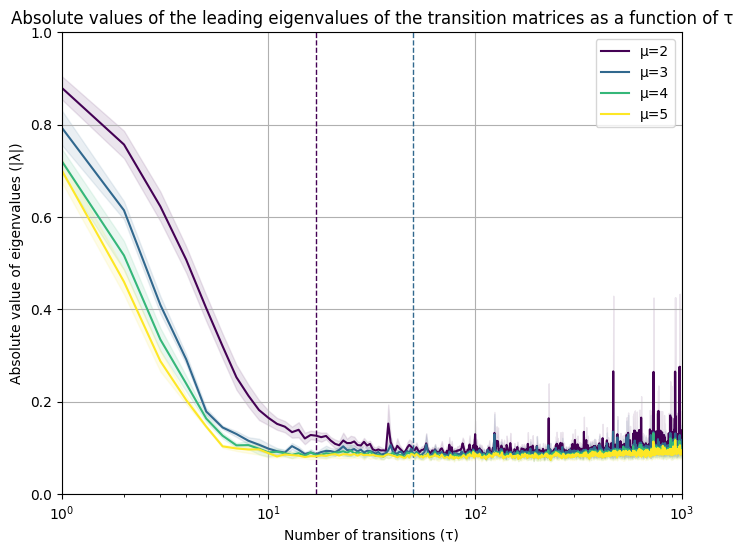

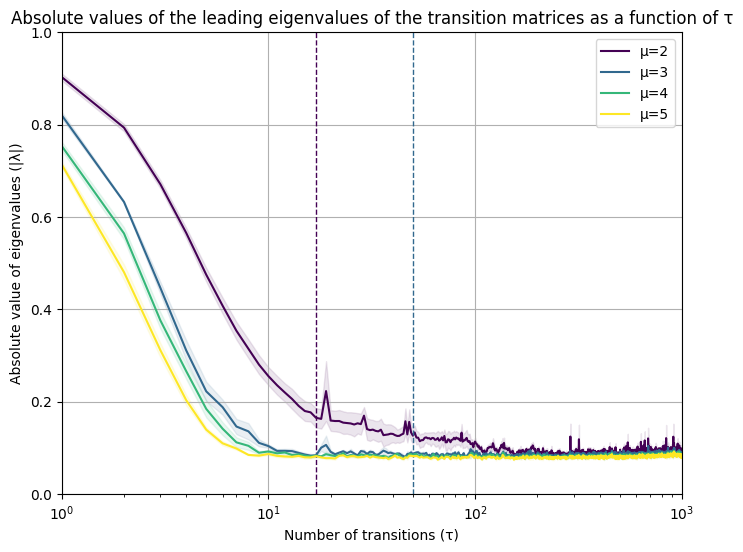

In [ ]:
tau_list = np.arange(1, 1001)  # Example tau values ## must include 1
mu_list = [2,3,4,5]  # Example mu values
k_list=[17,50,100,112]
eigenvalues_abs_WT_dict, eigenvalue_abs_WT_means, eigenvalue_abs_WT_sems = plot_longtime_transition_matrices_test(labels_WT_list, n_clusters, tau_list, mu_list, k_list)
eigenvalues_abs_AD_dict, eigenvalue_abs_AD_means, eigenvalue_abs_AD_sems = plot_longtime_transition_matrices_test(labels_AD_list, n_clusters, tau_list, mu_list,k_list)

/tmp/ipykernel_907621/2493311141.py:35: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_907621/3155650032.py:34: RuntimeWarning: divide by zero encountered in log
  decay_rate = -np.log(np.abs(predicted_eigenvalues)) / tau


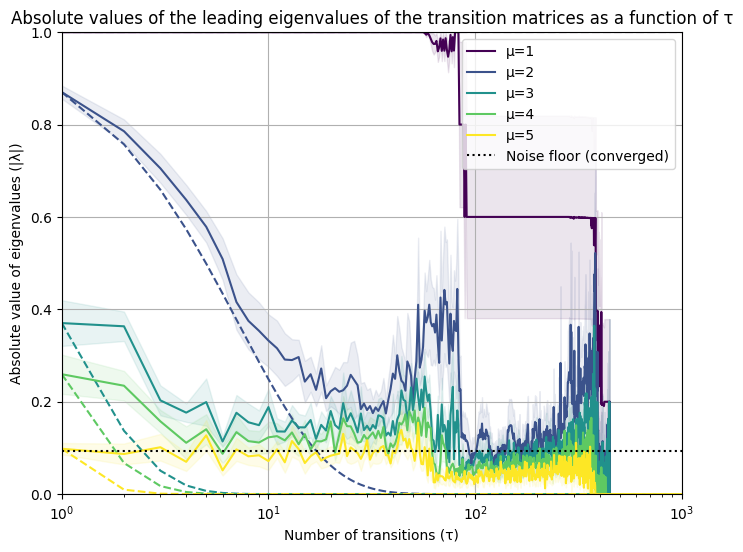

In [ ]:
tau_list = np.arange(1, 1001)  # Example tau values ## must include 1
mu_list = [1,2,3,4,5]  # Example mu values
eigenvalues_abs_WT_dict, eigenvalue_abs_WT_means, eigenvalue_abs_WT_sems = plot_longtime_transition_matrices(labels_WT_list, n_clusters, tau_list, mu_list)

/tmp/ipykernel_907621/2493311141.py:35: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
/tmp/ipykernel_907621/3155650032.py:34: RuntimeWarning: divide by zero encountered in log
  decay_rate = -np.log(np.abs(predicted_eigenvalues)) / tau


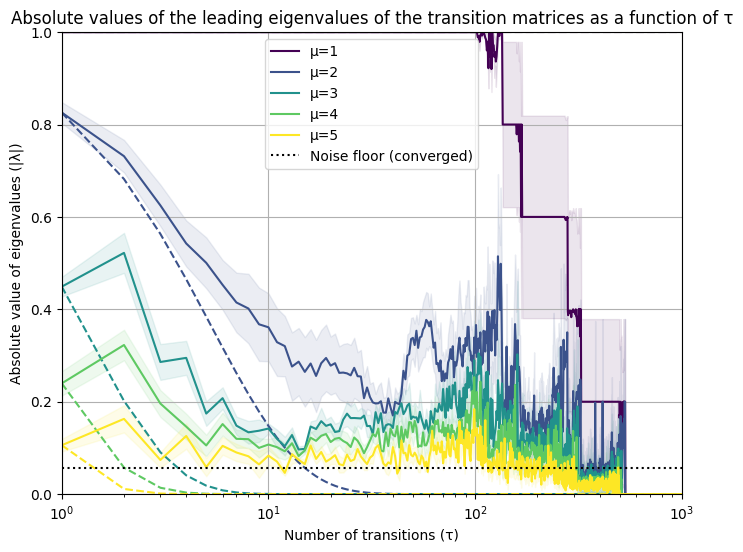

In [ ]:
tau_list = np.arange(1, 1001)  # Example tau values ## must include 1
mu_list = [1,2,3,4,5]  # Example mu values
eigenvalues_abs_AD_dict, eigenvalue_abs_AD_means, eigenvalue_abs_AD_sems = plot_longtime_transition_matrices(labels_AD_list, n_clusters, tau_list, mu_list)

In [ ]:
#### Comparison of decay plot(mu) between groups 
# (mu,tau): (2,17) (3,50)
mu = 3
tau = 50
WT_mu_decay = [x[mu - 1] for x in eigenvalue_abs_WT_means]
AD_mu_decay = [x[mu - 1] for x in eigenvalue_abs_AD_means]

perform_tests(WT_mu_decay[:tau],AD_mu_decay[:tau])


Eigenvalues 1 Normality P-value: 2.296051997176302e-13
Eigenvalues 2 Normality P-value: 4.757495303911882e-13
One or both groups are not normally distributed. Performing Mann-Whitney U test.
Mann-Whitney U Statistic (p-value): 0.04447899727755185
KS Statistic (p-value): 0.11238524845512393


('u-test', 0.04447899727755185, 0.11238524845512393)

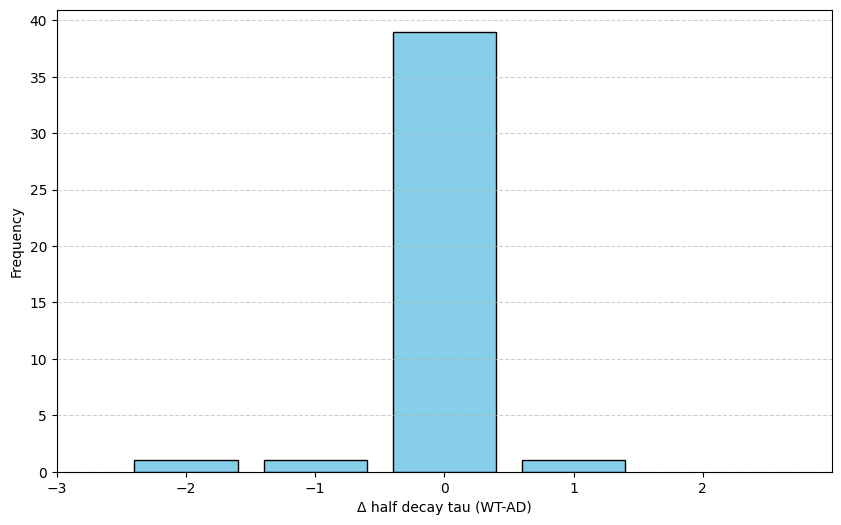

In [ ]:
#### Half-lives comparison
# num_mu : 43, num_tau : 1000
def find_half_decay_index(value_list):
    """
    주어진 리스트에서 첫 번째 값의 절반에 도달하는 인덱스를 반환합니다.
    Args:
        value_list (list or np.ndarray): 정렬된(내림차순) 값의 리스트.
    Returns:
        int: 첫 번째 값의 절반에 도달하는 인덱스. (없으면 None)
    """
    start_value = value_list[0]  # 첫 번째 값
    # 값의 로그 절반을 구하기 위해 먼저 로그를 취하고, 절반 값을 구합니다.
    half_value_log = np.log(start_value) - np.log(2)  # 로그로 절반 값 계산

    # 로그 값 기준으로 절반에 도달하는 인덱스를 찾습니다
    for idx, value in enumerate(value_list):
        if np.log(value) <= half_value_log:  # 로그 값이 절반 이하일 때 인덱스 반환
            return idx

    # 절반 값 이하로 내려가지 않으면 None 반환
    return None

def plot_value_histogram(values):
    """
    주어진 정수 리스트의 각 값의 빈도를 히스토그램으로 표시합니다.
    
    Args:
        values (list or np.ndarray): 정수값이 포함된 리스트.
    """
    # 히스토그램 그리기
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=range(min(values), max(values) + 2), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
    
    # min과 max의 절댓값 중 큰 값을 사용하여 x축 범위 설정
    max_abs_value = max(abs(min(values)), abs(max(values)))
    plt.xlim([-max_abs_value-1, max_abs_value+1])  # 0을 중심으로 범위 설정

    # x축에 정수 값만 표시
    plt.xticks(range(-max_abs_value-1, max_abs_value + 1)) if max_abs_value <10 else plt.xticks(range(-max_abs_value-1, max_abs_value + 1,max_abs_value//5))
    
    # 레이블과 제목 설정
    plt.xlabel("Δ half decay tau (WT-AD)")
    plt.ylabel("Frequency")
    #plt.title("Histogram o")
    
    # 그리드 설정
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    # 시각화
    plt.show()

num_mu = 43
num_tau = 1000
WT_half_decay_tau = []
AD_half_decay_tau = []

for mu in range(2,num_mu+1): # mu=1 pass
    WT_mu_decay = [x[mu - 1] for x in eigenvalue_abs_WT_means]
    AD_mu_decay = [x[mu - 1] for x in eigenvalue_abs_AD_means]

    WT_half_decay_index = find_half_decay_index(WT_mu_decay)
    AD_half_decay_index = find_half_decay_index(AD_mu_decay)

    WT_half_decay_tau.append(WT_half_decay_index)
    AD_half_decay_tau.append(AD_half_decay_index)

# Convert lists to numpy arrays for element-wise operations
WT_half_decay_tau_array = np.array(WT_half_decay_tau)
AD_half_decay_tau_array = np.array(AD_half_decay_tau)

# Calculate element-wise difference
diff_WT_AD = []

for wt, ad in zip(WT_half_decay_tau_array, AD_half_decay_tau_array):
    if wt is None or ad is None:
        diff_WT_AD.append(None)
    else:
        diff_WT_AD.append(wt - ad)

plot_value_histogram([x for x in diff_WT_AD if x is not None]) 

In [ ]:
tau_list = [1,2,3,5,10]

# AD
_, eigenvalues_dict_AD, _ = compute_transition_matrices_and_eigenvalues(labels_AD_list, n_clusters, tau_list)
eigenvalue_means_AD, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_dict_AD, tau_list)

# WT
_, eigenvalues_dict_WT, _ = compute_transition_matrices_and_eigenvalues(labels_WT_list, n_clusters, tau_list)
eigenvalue_means_WT, eigenvalue_sems = calculate_eigenvalue_means_and_sems(eigenvalues_dict_WT, tau_list)

compare_eigenvalues(eigenvalues_dict_AD[0], eigenvalues_dict_AD[5], 'AD_tau_1', 'AD_tau_10')
compare_eigenvalues(eigenvalues_dict_AD[0], eigenvalues_dict_WT[0], 'AD_tau_1', 'WT_tau_1')
compare_eigenvalues(eigenvalues_dict_AD[5], eigenvalues_dict_WT[5], 'AD_tau_10', 'WT_tau_10')

In [ ]:
tau_list = np.arange(1, 1001)  # Example tau values ## must include 1
mu_list = [2,3,4,5,10]  # Example mu values
eigenvalues_abs_dict, eigenvalue_abs_means, eigenvalue_abs_sems = plot_longtime_transition_matrices(labels_AD_list, n_clusters, tau_list, mu_list)

In [ ]:
tau_list = np.arange(1, 10001)  # Example tau values ## must include 1
mu_list = [2,5,10,20,30,50]  # Example mu values
plot_longtime_transition_matrices2(labels_AD_list, n_clusters, tau_list, mu_list)